Generate rooftop dataset from Inira aerial imagery terms of Json formatted GT data for polygonRNN format

### Inira dataset

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
image = cv2.imread('./data/AerialImageDataset/train/gt/austin18.tif')

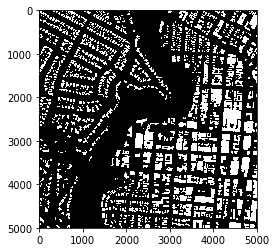

In [4]:
plt.imshow(image)
plt.show()

### Detecting boundary corners of each individual building

In [5]:
img = image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#find Harris corners
gray = np.float32(gray)

dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
dst = np.uint8(dst)

#find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

#define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
#here u can get corners
print (corners)

#Now draw them
# res = np.hstack((centroids,corners)) 
# res = np.int0(res) 
# img[res[:,1],res[:,0]]=[0,0,255] 
# img[res[:,3],res[:,2]] = [0,255,0]
# cv2.imwrite('1.png',img)

[[ 2.4991877e+03  2.5010774e+03]
 [ 2.6267987e+02 -6.3512586e-03]
 [ 3.2556223e+02  1.0851650e+00]
 ...
 [ 4.0954417e+03  4.9985586e+03]
 [ 4.7583750e+03  4.9939673e+03]
 [ 4.7583750e+03  4.9939673e+03]]


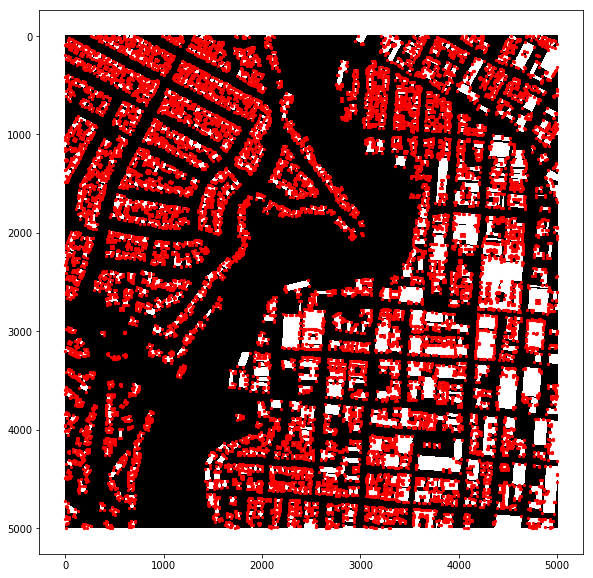

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.scatter(corners[1:,0],corners[1:,1], c = 'r', s = 5)
plt.savefig('./processed.png')

# Instance segmentation using contour plots.

In [7]:
image = cv2.imread('./data/AerialImageDataset/train/gt/austin10.tif')
img = np.copy(image[4500:5000,0:500]) #Image matrix

In [8]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #Convert any colors to B/W

#find contour levels.
ret, thresh = cv2.threshold(gray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_TC89_KCOS)
output = 5
contours2 = cv2.approxPolyDP(contours[2], 2, True)

In [9]:
#print(contours2)

In [10]:
#print(hierarchy[0])

In [11]:
print(img[0:1000,400:600].shape)

(500, 100, 3)


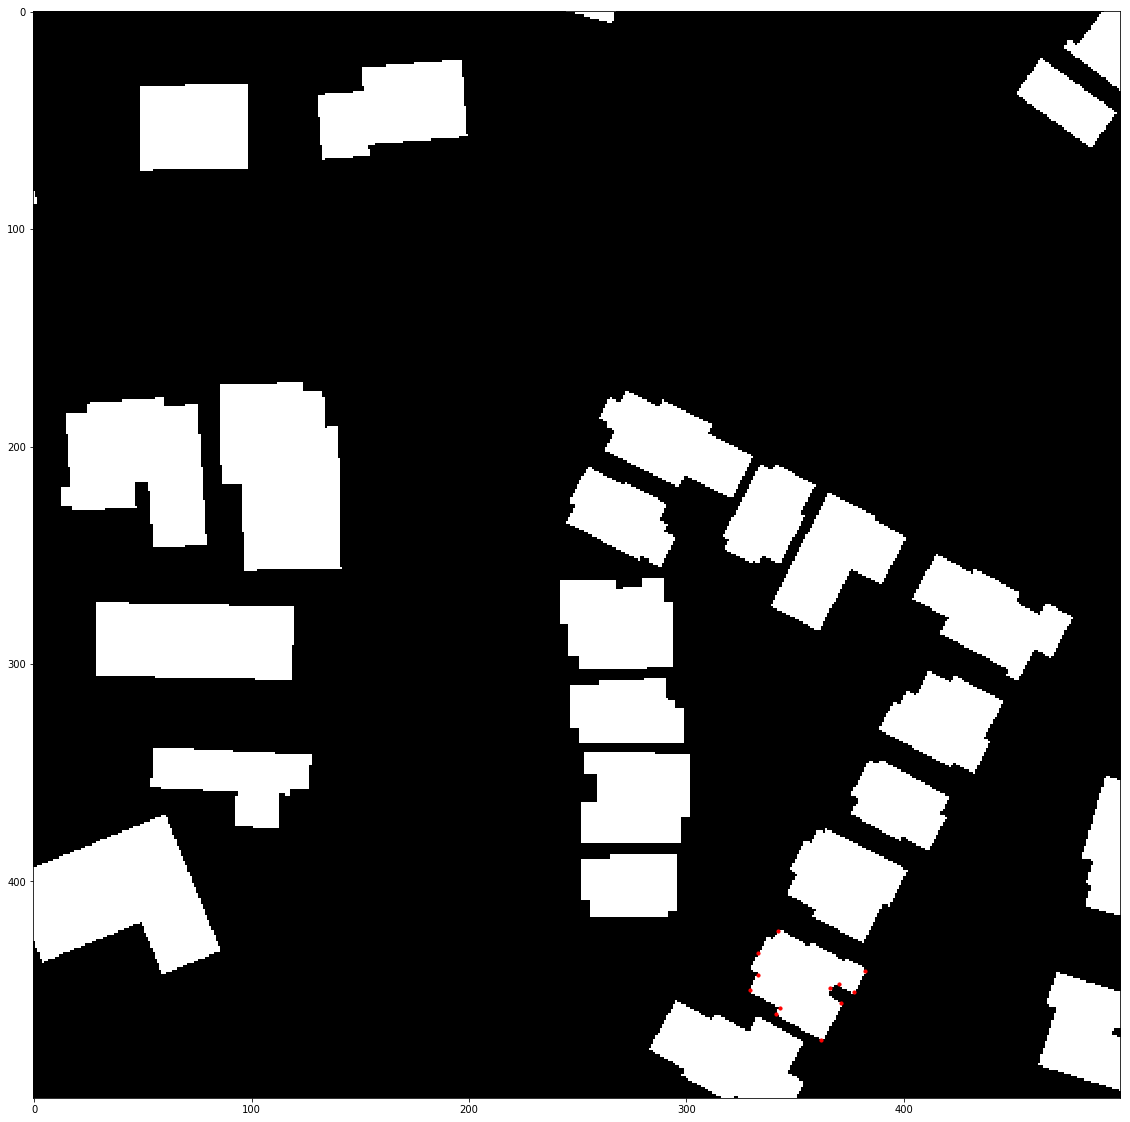

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(img)
for plot in contours2:
    plt.scatter(plot[0][0], plot[0][1], c='r', s=10)
# plt.scatter(corners[1:,0],corners[1:,1], c = 'r', s = 5)
plt.savefig('./processed.png')

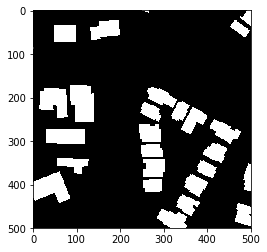

In [13]:
plt.imshow(img,cmap='gray')

# Selecting individual buildings from the mask. 

In [14]:
#Given the city mask, the below code segments the dataset to individual buildings
#It also detects edge corners and produces a outline of the building
#Each building is also displayed from the original satelite image

In [15]:
import os
import json

In [16]:
#Hyperparameters
train_images = ['austin7','austin8','austin9','austin10','austin11','austin12','austin13','austin14','austin15','austin16']
train_val_images = ['austin17']
val_images = ['austin18',]
gt_path = './data/AerialImageDataset/train/gt/'
sat_path = './data/AerialImageDataset/train/images/'
data_path = './data/genTrain/'
meta_path = './data/genMeta'


In [17]:
"""
Class responsible for loading the image and processing corners
"""
class SatImage:
    #folderName is the name of the dataset.
    #gtImg is the path to the GT mask of the satImage
    #satImg is the path to the sattelite image
    #trainType = train / train_val / val
    def __init__(self, folderName, gtImg, satImg, trainType):
        self.gtImage = cv2.imread(gtImg)
        self.satImage = cv2.imread(satImg)
        self.folderName = folderName
        self.trainType = trainType
        
        assert self.satImage.shape[0] == self.gtImage.shape[0]
        assert self.gtImage.shape[0] == self.gtImage.shape[0]
        
        self.xdim = self.satImage.shape[0]
        self.ydim = self.satImage.shape[1]
        
        self.buildingCorners = self.__detectCorners(self.gtImage)

        
    #Create the dataset, saving it of metaType
    def createDataset(self, metaType = 'json'):
        
        for idx in range(len(self.buildingCorners)):
            
            try:
                buildingArray, bboxArray, image = self.generateDataBuilding(self.buildingCorners[idx],20)
            except:
                continue
#             print(bboxArray)
            instance_id = self.folderName+'_'+str(idx)

            imagePath = os.path.join(data_path,self.trainType,self.folderName,instance_id)+'.png'
            if not os.path.exists(os.path.dirname(imagePath)):
                os.makedirs(os.path.dirname(imagePath))

            #Save the image
            cv2.imwrite(imagePath,image)
            #Save the metadata.
            if (metaType == 'json'):
                jsonPath = os.path.join(meta_path,self.trainType,self.folderName,instance_id)+'.json'
                if not os.path.exists(os.path.dirname(jsonPath)):
                    os.makedirs(os.path.dirname(jsonPath))
                self.__saveJson(jsonPath, imagePath, bboxArray, buildingArray, image.shape[0],image.shape[1], instance_id)

        print("Created image")
#        #Plot figure and our corner points
#         fig = plt.figure(figsize=(4,4), frameon=False)
#         ax = plt.Axes(fig, [0., 0., 1., 1.])
#         ax.set_axis_off()
#         fig.add_axes(ax)

#         ax.imshow(image, origin='lower')
#         ax.scatter(buildingArray[:,0], buildingArray[:,1], c='r', s=10)
#         fig.savefig(imagePath)

    def __saveJson(self, jsonPath, imagePath, bboxArray, buildingArray, img_width, img_height, instance_id):
        metaData = {
            "city":self.folderName,
            "img_path":'.'+imagePath,
            "deepmask_path":"none/deepmask/id.npz",
            "feats_path":"none/dilation_feats/id.npz",
            "img_width":img_width,
            "edge_path":"none/citiscapes_edges/id.png",
            "label":"roof",
            "instance_id":instance_id+"_1",
            "image_id":instance_id,
            "img_height":img_height,
            "split":self.trainType,
            "components":[
                {
                    "bbox":bboxArray.tolist(),
                    "poly":buildingArray.tolist(),
                    "area":1000
                }
            ],
            "dilation_path":"none/segmentation_dilation/id.png",
            "bbox":bboxArray.tolist()
        }
        
#         meta = json.dumps(metaData, sort_keys=False)
#         print(app_json)
        with open(jsonPath, 'w') as json_file:
            json.dump(metaData, json_file)
        
    #Show the original image
    def showOriginals(self):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(self.gtImage)
        axarr[1].imshow(self.satImage)
        
    
    #Detect all the corners in the mask.
    def __detectCorners(self, gtMask):
        #Corner detection
        gray = cv2.cvtColor(gtMask,cv2.COLOR_BGR2GRAY) #Convert any colors to B/W
        ret, thresh = cv2.threshold(gray, 127, 255, 0) #The threshold of our mask.
        #Threshold of detection. RETR_EXTERNAL = Use only outer layer. Chaining with TC_KCOS
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_TC89_KCOS)
        
        #Smoothing of each detected object to reduce number of unwanted points
        smoothBuildingContours = []
        for building in contours:
            smoothed = cv2.approxPolyDP(building, 2, True)
            smoothed = smoothed.squeeze() #Reduce dim to x, y.
            smoothBuildingContours.append(smoothed)
        #List of coordinates
        return(smoothBuildingContours)

    #Check if building after cropped out is part of the Satellite image.
    def __checkValid(self,buildingArray, margin):
        max_x = max(buildingArray[:,0])
        max_y = max(buildingArray[:,1])
        min_x = min(buildingArray[:,0])
        min_y = min(buildingArray[:,1])
        if (max_x + margin) > self.xdim or (min_x - margin) < 0 :
            return(False)
        elif (max_y + margin) > self.ydim or (min_y - margin) < 0:
            return(False)
        else:
            return(True)

    #Generate the building dataset.
    #Returns cropped image and corner points.
    def generateDataBuilding(self,buildingArray, margin):
        buildingArray = np.copy(buildingArray)

        #Check if this building can be plotted
        if self.__checkValid(buildingArray, margin) == False:
            print("Coordinates not valid")
            return None

        max_x = max(buildingArray[:,0])
        min_x = min(buildingArray[:,0])
        max_y = max(buildingArray[:,1])
        min_y = min(buildingArray[:,1])

        #Reshape the corners to correspond to crop offset. 
        for i in range(buildingArray.shape[0]):
            buildingArray[i][0] -= (min_x-margin)
            buildingArray[i][1] -= (min_y-margin)

        #Create the bbox coordinates too. The format is (max x, max y, height, width).
        bboxArray = np.zeros(4).astype(int)
        bboxArray[0] = np.min(buildingArray[:,0])
        bboxArray[1] = np.min(buildingArray[:,1])
        bboxArray[2] = np.max(buildingArray[:,0]) - bboxArray[0]
        bboxArray[3] = np.max(buildingArray[:,1]) - bboxArray[1]
    
        #Crop out our image
        image = self.satImage[min_y-margin:max_y+margin,min_x-margin:max_x+margin]
        return(buildingArray, bboxArray, image)


#### Create training images

In [18]:
for idx in range(len(train_images)):
    data = SatImage(train_images[idx],gt_path+train_images[idx]+'.tif',sat_path+train_images[idx]+'.tif','train')
    data.createDataset('json')

Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinate

Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Created image
Coordinates not valid
Coordinates not valid
Coordinates not va

Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinate

#### Create train_val images

In [19]:
for idx in range(len(train_val_images)):
    data = SatImage(train_val_images[idx],gt_path+train_val_images[idx]+'.tif',sat_path+train_val_images[idx]+'.tif','train_val')
    data.createDataset('json')

Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinate

#### Create test images

In [20]:
for idx in range(len(val_images)):
    data = SatImage(val_images[idx],gt_path+val_images[idx]+'.tif',sat_path+val_images[idx]+'.tif','test')
    data.createDataset('json')

Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinates not valid
Coordinate

In [21]:
austin7.showOriginals()

NameError: name 'austin7' is not defined